# Translating multiomics single-cell data

This tutorial shows how to use the {class}`~moscot.problems.crss_modality.TranslationProblem` for integrating multiomics single-cell data, based on the method wich was firstly introduced in {cite}`demetci-scot:22`.

## Imports and data loading

In [1]:
import warnings

import moscot.plotting as mpl
from moscot.problems.cross_modality import TranslationProblem

import scanpy as sc
import anndata as ad
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing as pp

warnings.simplefilter("ignore", UserWarning)

/Users/ninasander/anaconda3/envs/moscot_env_1/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


### Dataset description

The preprocessed datset of bone marrow mononuclear cells is from the [Open Problems - Multimodal Single-Cell Integration* NeurIPS competition 2021](https://openproblems.bio/competitions/neurips_2021_docs/data/dataset.html). The samples were measured using the [10X Multiome Gene Expression and Chromatin Accessability kit](https://www.10xgenomics.com/products/single-cell-multiome-atac-plus-gene-expression). In this tutorial we will subset the multiome dataset on Site 1 , Donor 1.

In [2]:
adata_atac = sc.read('data/atac.h5ad')
adata_rna = sc.read('data/rna.h5ad')
adata_atac, adata_rna

(AnnData object with n_obs × n_vars = 6224 × 8000
     obs: 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
     var: 'feature_types', 'gene_id', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'ATAC_gene_activity_var_names', 'cell_type_colors', 'dataset_id', 'genome', 'hvg', 'neighbors', 'organism', 'umap'
     obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_norm', 'ATAC_lsi_red', 'ATAC_umap', 'X_umap', 'geneactivity', 'geneactivity_scvi', 'geneactivity_scvi_mde'
     layers: 'counts'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 6224 × 2000
     obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 

## Visualization
Let’s take a look at the ATAC and RNA data by plotting a UMAP of the respective domain before the alignment, colored accoring to cell type.

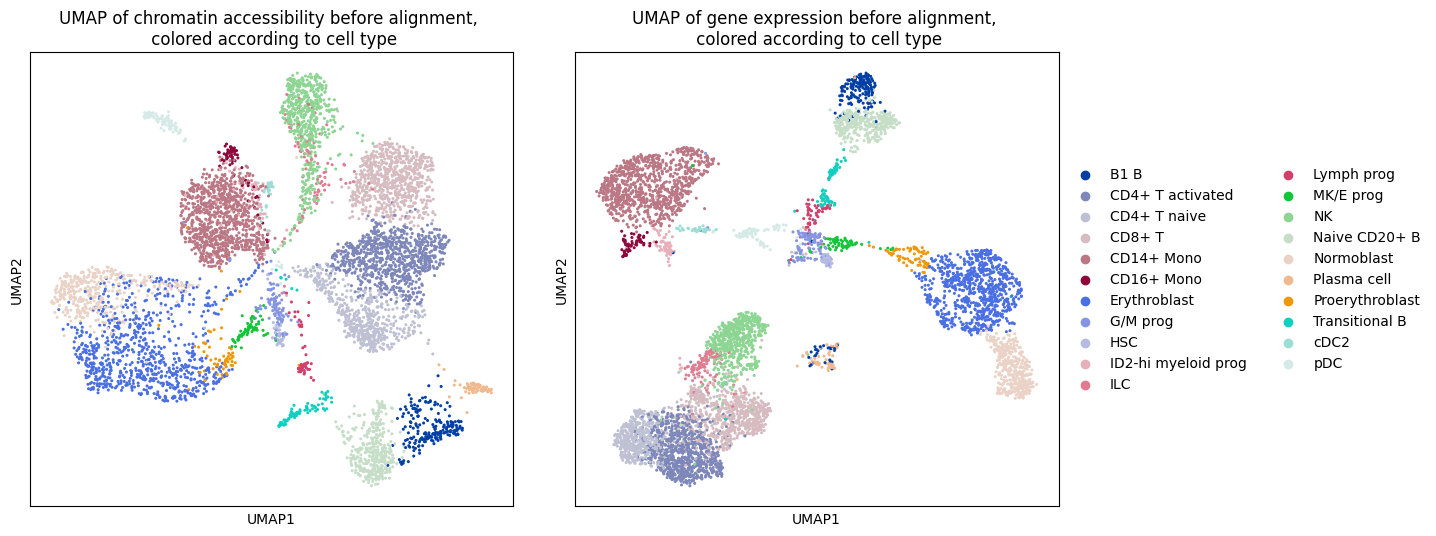

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_atac, color='cell_type', ax=ax1, show = False)
ax1.legend().remove()
ax1.set_title(
    "UMAP of chromatin accessibility before alignment, \n colored according to cell type"
)
sc.pl.umap(adata_rna, color='cell_type', ax=ax2, show = False)
#ax2.legend()
ax2.set_title(
    "UMAP of gene expression before alignment, \n colored according to cell type"
)
plt.tight_layout(pad=3.0)
plt.show()

## Translating multiomics single-cell data

With {mod}`moscot`, it is possible to learn a cell-to-cell alignment by leveraging Gromov-Wasserstein (GW) optimal transport.

### Prepare the {class}`~moscot.problems.cross_modality.TranslationProblem`

The moscot {class}`~moscot.problems.cross_modality.TranslationProblem` interfaces the GW algorithm in a user-friendly API. First, let's initialize the {class}`~moscot.problems.cross_modality.TranslationProblem` by passing source and target {class}`~anndata.AnnData` objects. In this tutorial, we will map the ATAC data to the gene expression domain.

In [4]:
tp = TranslationProblem(adata_src=adata_atac, adata_tgt=adata_rna)

After initialization, we need to {meth}`~moscot.problems.cross_modality.TranslationProblem.prepare` the problem. In this particular case, we need to pay attention to 3 parameters:

- `src_attr`: specify the attribute in {class}`~anndata.AnnData` that we want to use for the source data, for instance ATAC-seq measurements, whose LSI could be stored for example in {attr}`~anndata.AnnData.obsm`.
- `tgt_attr`: specify the attribute in {class}`~anndata.AnnData` that we want to use for the target data, for instance gene expression, whose PCA could be stored for example in {attr}`~anndata.AnnData.obsm`.
- `joint_attr`: optional, we can specify a joint attribute in order to incorporate a linear term into the quadratic optimization problem. Initially, we consider the pure Gromov-Wasserstein setting, and subsequently explore the fused problem.

In [5]:
tp = tp.prepare(
    src_attr={"attr": "obsm", "key": "ATAC_lsi_norm"},
    tgt_attr={"attr": "obsm", "key": "GEX_X_pca"}
)

### Solve the {class}`~moscot.problems.cross_modality.TranslationProblem`

We are now ready to {meth}`~moscot.problems.cross_modality.TranslationProblem.solve` the problem. In fused quadratic problems, the `alpha` parameter defines the convex combination between the quadratic and linear term. By default, `alpha = 1`, i.e. we only consider the quadratic problem, ignoring the `joint_attr`. We set `epsilon` to be relatively small to get a sparse mapping between cells.

In [6]:
tp = tp.solve(epsilon=1e-3, alpha=1.0)

INFO     Solving problem OTProblem[stage='prepared', shape=(6224, 6224)].                                          


### Translate the {class}`~moscot.problems.cross_modality.TranslationProblem`
We can now project one domain onto the other. The boolean paramter `forward` determines the direction of the barycentric projection. In our case, we project the source {class}`~anndata.AnnData` (`ATAC`) onto the target {class}`~anndata.AnnData` (`RNA`), therefore we use `forward = True`. The function {meth}`~moscot.problems.cross_modality.TranslationProblem.translate` returns the translated object in the target space (or source space respectively).

In [7]:
translated = tp.translate(source='src', target='tgt', forward=True)

#### Evaluate results
We will use the average FOSCTTM measure implemented below for evaluation (metric used in {cite}`demetci-scot:22`). This measure reports the fraction of samples closer to a sample than its true match (FOSCTTM), averaged over all samples (the smaller the better).

In [8]:
def foscttm(x,y):
    d = scipy.spatial.distance_matrix(x, y)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    fracs = []
    for i in range(len(foscttm_x)):
        fracs.append((foscttm_x[i]+foscttm_y[i])/2)
    return np.mean(fracs).round(4)

In [9]:
print("Average FOSCTTM score for this alignment with ATAC onto RNA is: ", foscttm(adata_rna.obsm['GEX_X_pca'], translated))

Average FOSCTTM score for this alignment with ATAC onto RNA is:  0.3676


### Extend the {class}`~moscot.problems.cross_modality.TranslationProblem` to the fused setting
We proceed to extend the {class}`~moscot.problems.cross_modality.TranslationProblem` to incorporate the fused setting. In this regard, we aim to evaluate the potential benefits of augmenting the quadratic problem with a linear term. Therefore, we {meth}`~moscot.problems.space.MappingProblem.prepare` a new problem, by employing a scVI integration of the gene activity data in the `joint_attr`. Then, we {meth}`~moscot.problems.cross_modality.TranslationProblem.solve` the resulting problem, with `alpha=0.9` and the epsilon parameter identical to that used in the pure Gromov-Wasserstein case.

In [10]:
ftp = TranslationProblem(adata_src=adata_atac, adata_tgt=adata_rna)
ftp = ftp.prepare(
    src_attr={"attr": "obsm", "key": "ATAC_lsi_norm"},
    tgt_attr={"attr": "obsm", "key": "GEX_X_pca"},
    joint_attr = 'geneactivity_scvi'
)
ftp = ftp.solve(epsilon=1e-3, alpha=0.9)
translated_fused = ftp.translate(source='src', target='tgt', forward=True)
print("Average FOSCTTM score for this fused alignment with ATAC onto RNA is: ", foscttm(adata_rna.obsm['GEX_X_pca'], translated_fused))

INFO     Solving problem OTProblem[stage='prepared', shape=(6224, 6224)].                                          
Average FOSCTTM score for this fused alignment with ATAC onto RNA is:  0.1015


The experimental results demonstrate a significant improvement in the fused setting when compared to the pure Gromov-Wasserstein case.

### Visualize translation
For the sake of visualization, we concatenate the translated chromatin accessibility points mapped to the gene expression PCA domain to the original gene expression PCA data. Then we plot a UMAP of the concatenated data in the gene expression domain, colored according to original domain and cell type.

In [11]:
adata = sc.concat([adata_atac, adata_rna], join = 'outer', label='batch')
adata.obsm['X_translated'] = np.concatenate((translated_fused, adata_rna.obsm['GEX_X_pca']), axis = 0)

/Users/ninasander/anaconda3/envs/moscot_env_1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


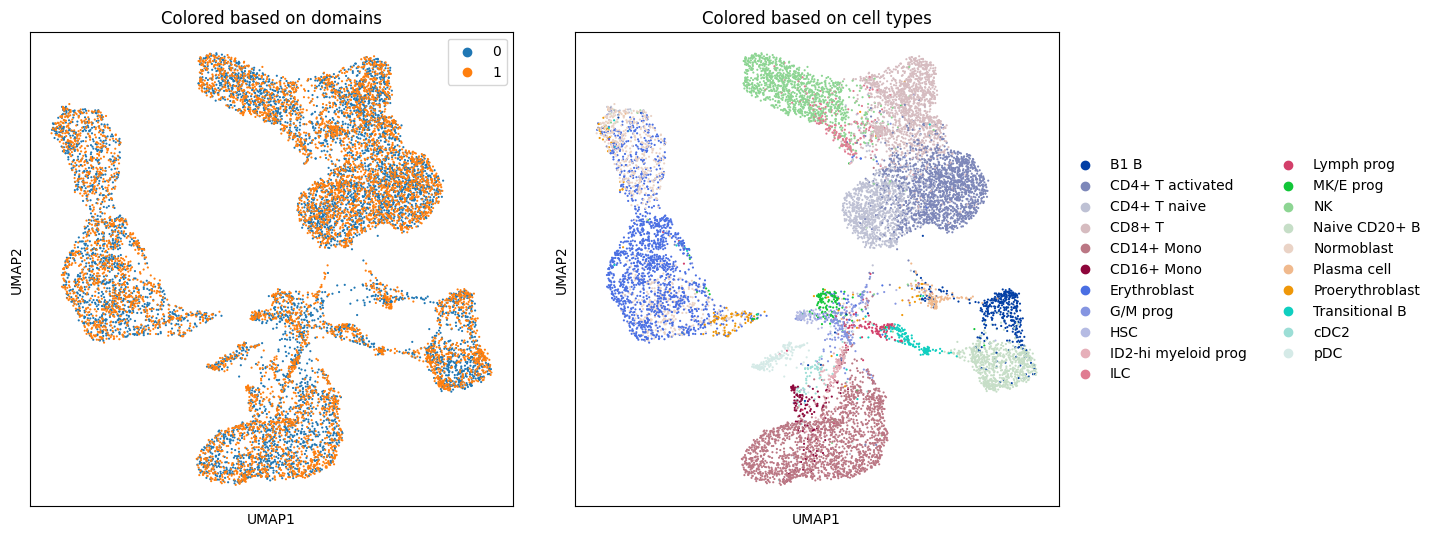

In [12]:
sc.pp.neighbors(adata, use_rep = 'X_translated')
sc.tl.umap(adata)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color = ['batch'], ax=ax1, show = False)
ax1.legend()
ax1.set_title("Colored based on domains")
sc.pl.umap(adata, color = ['cell_type'], ax=ax2, show = False)
#ax2.legend()
ax2.set_title("Colored based on cell types")
plt.tight_layout(pad=3.0)
plt.show()

### Analyze cell type transitions
The cell type transition matrix provides a mapping of cell types from one modality to another, and can be used to examine the correspondence between cell types across different datasets. The resulting matrix illustrates which cell types are mapped to where, thereby enabling further downstream analyses.

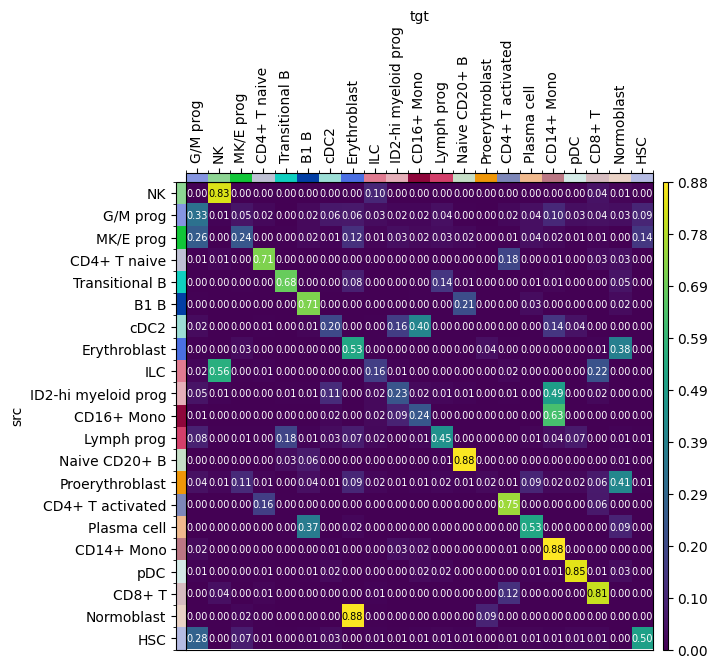

In [15]:
cell_transition = ftp.cell_transition(
    source='src', 
    target='tgt',
    source_groups="cell_type",
    target_groups="cell_type",
    forward=True,
    )
mpl.cell_transition(ftp, figsize=(5, 5))

The rows sum up to 1, as for each cell type in a certain row, the columns indicate where the cells are translated to. For example, Erythroblast cells are mainly mapped to Erythroblast cells in 53/100 cases, while a considerable number is also mapped to Normoblast cells. In contrast, CD14+ Mono cells are mapped to CD14+ Mono cells.